In [1]:
# just checking
import math
import os
import time
import random
import copy

from torchvision.datasets import CocoCaptions
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts
import torch.nn.init as init
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

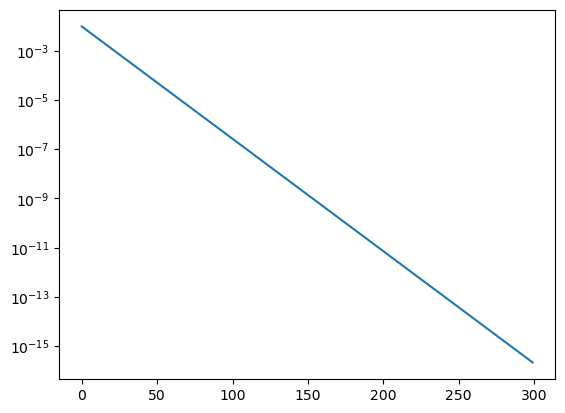

In [8]:
import numpy as np
lr = 1e-2
epochs = 300
eps = []
lrs = []
for i in range(epochs):
    eps.append(i)
    lrs.append(lr)
    lr *= 0.9

fig, ax = plt.subplots()
ax.plot(eps, lrs)
ax.set_yscale('log')
plt.show()

In [ ]:
image_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225])
])

In [ ]:
class CaptionPreprocessor:
    def __init__(self, captions, tokenizer, max_caption_length=20):
        self.tokenizer = tokenizer
        self.max_caption_length = max_caption_length
        self.captions_tokenized = self.tokenize_captions(captions)

    def preprocess(self, caption):
        tokens = self.tokenizer.tokenize(caption)
        caption_indices = self.tokenizer.convert_tokens_to_ids(tokens)

        if len(caption_indices) < self.max_caption_length:
            caption_indices += [self.tokenizer.pad_token_id] * (self.max_caption_length - len(caption_indices))

        return caption_indices[:self.max_caption_length]

    def tokenize_captions(self, captions):
        return [self.preprocess(caption) for caption in captions]

In [ ]:
class CustomCocoDataset(Dataset):
    def __init__(self, coco_dataset, caption_preprocessor, num_captions=5):
        self.coco_dataset = coco_dataset
        self.caption_preprocessor = caption_preprocessor
        self.num_captions = num_captions

    def __len__(self):
        return len(self.coco_dataset)

    def __getitem__(self, idx):
        img, caption_list = self.coco_dataset[idx]
        selected_caption = random.choice(caption_list[:self.num_captions])
        preprocessed_caption = torch.tensor(self.caption_preprocessor.preprocess(selected_caption))
        return img, preprocessed_caption

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, in_channels, embed_dim):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        init.xavier_uniform_(self.proj.weight)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class VisionTransformer(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim, num_layers, num_heads, mlp_dim, num_classes):
        super().__init__()
        self.patch_embed = PatchEmbedding(patch_size, in_channels, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, (224 // patch_size) * (224 // patch_size) + 1, embed_dim))

        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(embed_dim, num_heads, mlp_dim)
            for _ in range(num_layers)
        ])

        self.classification_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.positional_encoding[:, :-1]
        for layer in self.transformer_layers:
            x = layer(x)

        return x

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.encoding = nn.Parameter(torch.zeros(1, max_len, d_model), requires_grad=False)

        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, :, 0::2] = torch.sin(pos * div_term)
        self.encoding[:, :, 1::2] = torch.cos(pos * div_term)

    def forward(self, x):
        x = x + self.encoding[:, :x.size(1), :]
        return x


class TransformerCaptionDecoder(nn.Module):
    def __init__(self, auto_model, d_model, num_layers, num_heads, mlp_dim, max_len=128):
        super().__init__()

        self.auto_model = auto_model
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.transformer_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model, num_heads, mlp_dim)
            for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(d_model, self.auto_model.config.vocab_size)
        init.xavier_uniform_(self.output_layer.weight)

    def forward(self, captions, memory):
        captions = self.auto_model.embeddings(captions)
        captions = self.positional_encoding(captions)

        for layer in self.transformer_layers:
            captions = layer(captions, memory)

        logits = self.output_layer(captions)
        return logits

In [ ]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, image_encoder, caption_decoder):
        super(ImageCaptioningModel, self).__init__()
        self.image_encoder = image_encoder
        self.caption_decoder = caption_decoder
        self.start_token_index = caption_decoder.auto_model.config.bos_token_id or 0
        self.embedding_size = caption_decoder.auto_model.config.hidden_size
        self.image_feature_linear = nn.Linear(768, self.embedding_size)

    def forward(self, images, captions):
        image_features = self.image_encoder(images)
        num_patches = (224 // 16) * (224 // 16)
        # image_features_flattened = image_features.permute(1, 0, 2).reshape(-1, num_patches, self.embedding_size)

        start_token_tensor = torch.tensor([self.start_token_index], dtype=torch.long, device=images.device)
        start_token_embeddings = self.caption_decoder.auto_model.embeddings(start_token_tensor).repeat(image_features.shape[0], 1, 1) # getting start token embedding and repeating it for batch size
        image_features_summed = image_features.sum(dim=1).unsqueeze(1)
        image_features_summed = self.image_feature_linear(image_features_summed)
        memory = torch.cat([start_token_embeddings, image_features_summed], dim=1) # Concatenate the start token embeddings with the flattened image features

        memory = memory.transpose(0, 1)
        captions = captions.transpose(0, 1)

        output = self.caption_decoder(captions, memory)
        return output

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch, avg_every):
    model.train()
    train_loss = 0
    last_x_losses = []
    for i, (images, captions) in enumerate(tqdm(dataloader, desc='Training')):
    # for i, (images, captions) in enumerate(dataloader):
        images = images.to(device)
        captions_input = captions[:, :-1].to(device)
        captions_target = captions[:, 1:].to(device)

        optimizer.zero_grad()
        output = model(images, captions_input)

        loss = criterion(output.reshape(-1, 30522), captions_target.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        last_x_losses.append(loss.item())

        if i % avg_every == 0:
            avg_loss = sum(last_x_losses) / len(last_x_losses)
            print(f'Epoch: {epoch+1}, Iteration: {i}, Loss (last {avg_every} iterations): {avg_loss:.4f}')
    return train_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, captions in tqdm(dataloader, desc='Validating'):
        # for images, captions in dataloader:
            image = images.to(device)
            captions_input = captions[:, :-1].to(device)
            captions_target = captions[:, 1:].to(device)

            output = model(images, captions_input)
            loss = criterion(output.reshape(-1, 30522), captions_target.view(-1))

            val_loss += loss.item()
    return val_loss / len(dataloader)

In [ ]:
class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.current_step = 0

    def step(self):
        self.current_step += 1
        lr = self.learning_rate()
        for param_group in self.optimizer.param_groups:
            if param_group['lr'] != lr:
                print(f"Learning rate changed: {param_group['lr']} -> {lr}")
            param_group['lr'] = lr

    def learning_rate(self):
        arg1 = self.current_step ** -0.5
        arg2 = min(self.current_step * self.warmup_steps ** -1.5, 1)
        return (self.d_model ** -0.5) * min(arg1, arg2)

In [ ]:
def plot_and_save(train_losses, val_losses, learning_rates, max_min_loss_diffs):
    plt.style.use('classic')

    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(train_losses, label='Train Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.set_title('Training and Validation Losses', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid()
    ax.legend(fontsize=12)
    fig.savefig('losses.png')

    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(learning_rates, label='Learning Rate')
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Learning Rate', fontsize=14)
    ax.set_title('Learning Rate Schedule', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid()
    ax.legend(fontsize=12)
    fig.savefig('learning_rates.png')

    fig_ax = plt.subplots(figsize=(15, 6))
    ax.plot(max_min_loss_diffs, label='Loss Difference')
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Loss Difference', fontsize=14)
    ax.set_title('Difference Between Max and Min Loss per Epoch', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid()
    ax.legend(fontsize=12)
    fig.savefig('loss_differences.png')


In [ ]:
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
tokenizer_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

train_dataset = CocoCaptions(root='./coco/images',
                       annFile='./coco/annotations/captions_train2014.json',
                       transform=image_transform)
val_dataset = CocoCaptions(root='./coco/images',
                           annFile='./coco/annotations/captions_val2014.json',
                           transform=image_transform)
train_captions = [entry['caption'] for entry in train_dataset.coco.anns.values()]
val_captions = [entry['caption'] for entry in val_dataset.coco.anns.values()]

caption_preprocessor = CaptionPreprocessor(train_captions + val_captions, tokenizer)

max_caption_length_train = max([len(tokenized_caption) for tokenized_caption in caption_preprocessor.tokenize_captions(train_captions)])
max_caption_length_val = max([len(tokenized_caption) for tokenized_caption in caption_preprocessor.tokenize_captions(val_captions)])
max_caption_length = max(max_caption_length_train, max_caption_length_val)
print('Maximum caption length (without <start>, <end>, and <pad> tokens):', max_caption_length)

custom_train_dataset = CustomCocoDataset(train_dataset, caption_preprocessor, num_captions=5)
custom_val_dataset = CustomCocoDataset(val_dataset, caption_preprocessor, num_captions=5)

batch_size = 64
train_data_loader = DataLoader(custom_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_data_loader = DataLoader(custom_val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

image_encoder = VisionTransformer(in_channels=3,
                                  patch_size=16,
                                  embed_dim=768,
                                  num_layers=4,
                                  num_heads=16,
                                  mlp_dim=512,
                                  num_classes=768).to(device)

auto_model = AutoModel.from_pretrained(tokenizer_name).to(device)
caption_decoder = TransformerCaptionDecoder(auto_model=auto_model,
                                            d_model=768,
                                            num_layers=4,
                                            num_heads=16,
                                            mlp_dim=512).to(device)

model = ImageCaptioningModel(image_encoder, caption_decoder).to(device)

useTwoGPUs = True
if torch.cuda.device_count() > 1 and useTwoGPUs:
    print(f'Using {torch.cuda.device_count()} GPUs')
    model = nn.DataParallel(model)

num_epochs = 100

total_samples = len(train_data_loader.dataset)
batch_size = train_data_loader.batch_size
max_iterations = math.ceil(total_samples / batch_size)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=1e-3)  #, weight_decay=1e-5)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.67, patience=2, verbose=True)
# scheduler = NoamScheduler(optimizer, d_model=1600, warmup_steps=4000)
# scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=int(num_epochs / 5), eta_min=1e-6)

best_val_loss = float('inf')

train_losses = []
val_losses = []
learning_rates = []
max_min_loss_diffs = []

load_best_model = True
best_model_path = 'best_loss_model1.pt'
if load_best_model and os.path.exists(best_model_path):
    state_dict = torch.load(best_model_path)
    model.load_state_dict(state_dict)
    print('Loaded best saved model...')
    best_val_loss = evaluate(model, val_data_loader, criterion, device)
    print(f'Validation loss of hte loaded model: {best_val_loss:.4f}')

print('**********STARTING TRAINING**********')
training_start = time.time()
for epoch in range(num_epochs):
    epoch_start = time.time()

    epoch_max_loss = float('-inf')
    epoch_min_loss = float('inf')

    print(f'Total samples: {total_samples}, Batch size: {batch_size}, Maximum iterations: {max_iterations}')

    avg_every = 25
    train_loss = train_one_epoch(model, train_data_loader, criterion, optimizer, device, epoch, avg_every)
    val_loss = evaluate(model, val_data_loader, criterion, device)
    print(f'VALIDATION LOSS FOR EPOCH {epoch + 1}: {val_loss:.4f}')

    epoch_end = time.time()
    print(f'Epoch {epoch+1} total time: {epoch_end - epoch_start}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss

        save_name = f'best_loss_model1.pt'
        torch.save(model.state_dict(), save_name)
        print(f'**********NEW BEST MODEL SAVED @ VAL: {best_val_loss}**********')

    scheduler.step(val_loss)

training_end = time.time()
print(f'Total training time: {training_end - training_start}')

plot_and_save(train_losses, val_losses, learning_rates, max_min_loss_diffs)


In [ ]:

    # epoch_train_start = time.time()
    # for i, (images, captions) in enumerate(train_data_loader):
    #     images = images.to(device)
    #     captions_input = captions[:, :-1].to(device)
    #     captions_target = captions[:, 1:].to(device)
    #
    #     optimizer.zero_grad()
    #     output = model(images, captions_input)
    #
    #     loss = criterion(output.reshape(-1, 28796), captions_target.view(-1))
    #     loss.backward()
    #     optimizer.step()
    #
    #     train_loss += loss.item()
    #
    #     if loss.item() > epoch_max_loss:
    #         epoch_max_loss = loss.item()
    #         print(f'Max loss set to: {epoch_max_loss}')
    #     if loss.item() < epoch_min_loss:
    #         epoch_min_loss = loss.item()
    #         print(f'Min loss set to: {epoch_min_loss}')
    #
    #     if i % 50 == 0:
    #         print(f'Epoch: {epoch+1}/{num_epochs}, Iteration: {i}, Loss: {loss.item()}')
    #
    # epoch_train_end = time.time()
    # epoch_train_time = epoch_train_end - epoch_train_start
    # print(f'Epoch {epoch+1} training time: {epoch_train_time}')
    #
    # epoch_max_min_diff = epoch_max_loss - epoch_min_loss
    # if epoch + 1 != 1:
    #     max_min_loss_diffs.append(epoch_max_min_diff)
    # print(f'Difference between max and min loss in epoch {epoch+1}: {epoch_max_min_diff}')
    #
    # train_loss /= len(train_data_loader)
    #
    # model.eval()
    # val_loss = 0

#     epoch_val_start = time.time()
#     with torch.no_grad():
#         for images, captions in val_data_loader:
#             images = images.to(device)
#             captions_input = captions[:, :-1].to(device)
#             captions_target = captions[:, 1:].to(device)
#
#             output = model(images, captions_input)
#             loss = criterion(output.reshape(-1, 28796), captions_target.view(-1))
#
#             val_loss += loss.item()
#
#     epoch_val_end = time.time()
#     epoch_val_time = epoch_val_end - epoch_val_start
#     print(f'Epoch {epoch+1} validation time: {epoch_val_time}')
#
#     epoch_end = time.time()
#     epoch_time = epoch_end - epoch_start
#     print(f'Epoch {epoch+1} total time: {epoch_time}')
#
#     val_loss /= len(val_data_loader)
#     print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
#     learning_rates.append(optimizer.param_groups[0]['lr'])
#
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#
#         if os.path.exists(save_name):
#             os.remove(save_name)
#
#         save_name = f'best_loss_model_{epoch}.pth'
#         torch.save(model.state_dict(), save_name)
#
#     scheduler.step()
#
# training_end = time.time()
# training_time = training_end - training_start
# print(f'Total training time: {training_time}')
#
# plot_and_save(train_losses, val_losses, learning_rates, max_min_loss_diffs)